In [83]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
import numpy as np

In [84]:
class DatasetLoader:
    def __init__(self, tfrecord_file, image_shape=[480, 640, 3], lasers_shape=513, goal_shape=2, motion_command_shape=3):
        self.tfrecord_file = tfrecord_file
        self.image_shape = image_shape
        self.lasers_shape = lasers_shape
        self.goal_shape = goal_shape
        self.motion_command_shape = motion_command_shape
        self.dataset_length = self._get_dataset_length()

    def _parse_function_with_images(self, proto):
        features = {
            'image': tf.io.FixedLenFeature([], tf.string),  # Raw serialized image
            'goal': tf.io.FixedLenFeature([self.goal_shape], tf.float32),
            'motion_command': tf.io.FixedLenFeature([self.motion_command_shape], tf.float32)
        }
        
        # Parse the input `proto` based on the defined features
        parsed_features = tf.io.parse_single_example(proto, features)    

        # Deserialize and reshape the raw image tensor
        image = tf.io.parse_tensor(parsed_features['image'], out_type=tf.uint8)
        image = tf.reshape(image, self.image_shape)
        
        return (image, parsed_features['goal']), parsed_features['motion_command']

    def _get_dataset_length(self):
        dataset = tf.data.TFRecordDataset(self.tfrecord_file)
        metadata_features = {
            'metadata': tf.io.FixedLenFeature([], tf.string, default_value=''),
            'length': tf.io.FixedLenFeature([], tf.int64, default_value=-1)
        }
        
        for record in dataset.take(1):
            parsed_features = tf.io.parse_single_example(record, metadata_features)
            dataset_length = parsed_features['length'].numpy()
            return dataset_length
        
        print("Metadata not found. Setting length to None.")
        return None

    def load_dataset(self):
        dataset = tf.data.TFRecordDataset(self.tfrecord_file)
        dataset = dataset.skip(1).map(self._parse_function_with_images, num_parallel_calls=tf.data.AUTOTUNE)
        return dataset

    def split_dataset(self, dataset, train_size=0.7, val_size=0.2):
        num_elements = self.dataset_length
        if num_elements is None:
            raise ValueError("Dataset length is not set. Ensure the metadata is properly included in the TFRecord.")
        
        train_end = int(train_size * num_elements)
        val_end = int((train_size + val_size) * num_elements)
        
        train_dataset = dataset.take(train_end)
        val_dataset = dataset.skip(train_end).take(val_end - train_end)
        test_dataset = dataset.skip(val_end).take(num_elements - val_end)
        
        return train_dataset, val_dataset, test_dataset

    def preprocess_and_augment(self, dataset_, batch_size=128):
        dataset_= dataset_.shuffle(buffer_size=10000).batch(batch_size).repeat()
        dataset_ = dataset_.prefetch(tf.data.AUTOTUNE)
        return dataset_

    def get_prepared_datasets(self, train_size=0.7, val_size=0.2, batch_size=128):
        dataset = self.load_dataset()
        train_dataset, val_dataset, test_dataset = self.split_dataset(dataset, train_size, val_size)
        del dataset
        train_dataset = self.preprocess_and_augment(train_dataset, batch_size)
        val_dataset = self.preprocess_and_augment(val_dataset, batch_size)
        test_dataset = self.preprocess_and_augment(test_dataset, batch_size)
        
        return train_dataset, val_dataset, test_dataset

In [85]:

def get_intermediate_outputs(model, image_input, layer_name):
    # Create a new model that outputs the activations of a specific layer
    intermediate_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    
    # Get the activations for the given input image
    activations = intermediate_model.predict(image_input)

    return activations
    
def visualize_intermediate_layers(activations, num_columns=4):
    
    # Number of feature maps (channels)
    num_features = activations.shape[-1]
    
    # Determine the number of rows needed based on the number of columns
    num_rows = num_features // num_columns
    if num_features % num_columns != 0:
        num_rows += 1
    
    # Create a figure for displaying the feature maps with a larger size
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows*4))  # Increase the figsize
    axes = axes.flatten()  # Flatten the axes to make indexing easier
    
    # Normalize activations for better visibility (optional)
    activations = np.maximum(activations, 0)  # ReLU-like activation to avoid negative values
    activations -= activations.min()  # Normalize to [0, 1] range
    activations /= activations.max()
    
    # Plot each feature map
    for i in range(num_features):
        ax = axes[i]
        ax.imshow(activations[0, :, :, i], cmap='viridis')  # Show the feature map
        ax.axis('off')
    
    # Hide empty subplots if the number of feature maps is not a perfect multiple of num_columns
    for j in range(num_features, len(axes)):
        axes[j].axis('off')
    
    # Adjust layout and make sure the images fit within the figure
    plt.subplots_adjust(hspace=0.3, wspace=0.3) 
    plt.show()


In [86]:
input_dir= "/work/nselva2s/rnd/robile_data_corr_07112024"
tfrecord_file= "tfrecords/corr_07112024_withImages.tfrecord"
tf_file = os.path.join(input_dir, tfrecord_file)
loader = DatasetLoader(tf_file)
train_dataset, val_dataset, test_dataset = loader.get_prepared_datasets()

In [87]:
model_path = '/work/nselva2s/rnd/robile_data_corr1/corr1_goal_img_downsampled_data_res_200epochs.keras'
model = tf.keras.models.load_model(model_path, compile=False)

In [88]:
(image_batch, goal_batch) , _= next(iter(train_dataset))
image_sample = image_batch[0]  # Get the first image in the batch
goal_sample = goal_batch[0] 

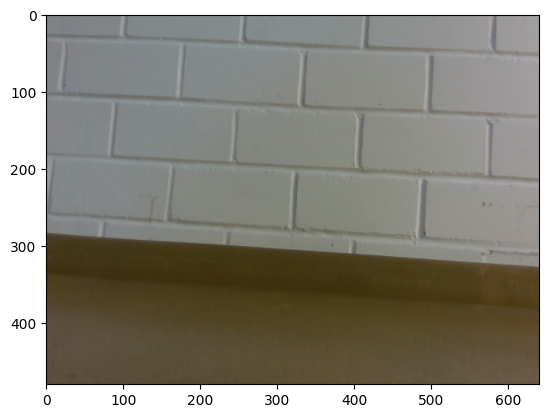

In [89]:
plt.imshow(image_sample)

In [90]:
activations = get_intermediate_outputs(model, [image_sample[None, ...], goal_sample[None, ...]], layer_name='block_13_expand_relu')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step


In [91]:
visualize_intermediate_layers(activations)

In [92]:
activations = get_intermediate_outputs(model, [image_sample[None, ...], goal_sample[None, ...]], layer_name='block_6_expand_relu')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


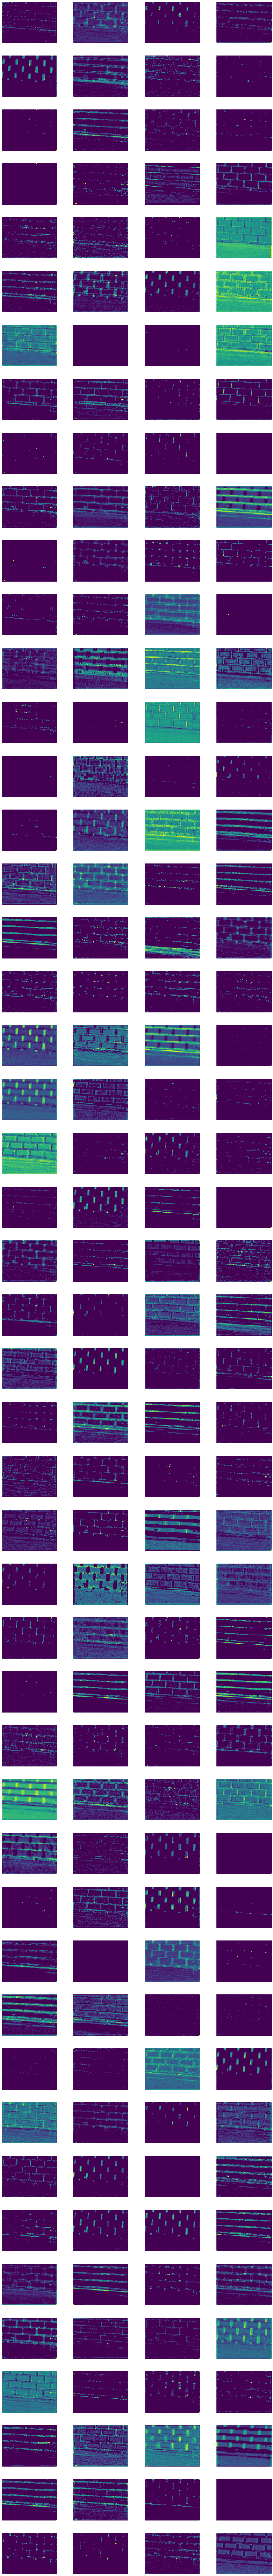

In [93]:
visualize_intermediate_layers(activations)